# EarthShape Phase 2: Overview of time-slice simulations

This notebook provides a brief overview of the simulated timeslices and some examples for working with the netcdf files produced by the postprocessing tooling for [EarthShape](http://earthshape.net/) Phase 2.

__________________
<img src="images/logo_earthshape.png" width="330" align="right">

Christian Werner  
christian.werner@kit.edu  
IMK-IFU, Karlsruhe Institute for Technology, Garmisch-Partenkirchen  
2019-06-01

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as plt
import matplotlib.ticker as mticker
import pandas as pd
from pathlib import Path
import sys
import xarray as xr
from IPython.display import Markdown, display, HTML

def check_version():
    def rtext(t): return '<span style="color: #ff0000">'+t+'</span>'
    if float('.'.join([str(x) for x in sys.version_info[0:2]] )) < 3.6:
        display(Markdown(rtext('This notebook is written for Python 3.6 and up!')))
        
check_version()

### Constants

In [3]:
ts = ['pre_industrial', 'lgm', 'pliocene', 'middle_miocene']
tsl = dict(zip(ts, ['Pre-Ind.', 'LGM', 'Pliocene', 'Mid. Miocene']))

sites = ['Nahuelbuta', ' La Campana', ' St. Gracia', ' Pan de Azucar']
sites_short = ['4','3','2','1']
coords = [(-37.80904, -73.01382), (-32.92905, -71.08846), (-29.75214, -71.15750), (-26.11008, -70.55039)]
site_coords = dict(zip(ts, coords))
df_sites = pd.DataFrame(dict(site=sites, siteno=sites_short, coord=coords)).sort_values(by='siteno').reset_index(drop=True)

### Utility functions

In [4]:
# extend path object
Path.ls = lambda x: [o.name for o in x.iterdir()]

# nicer plots
def beautify_map(ax, label=None, add_marker=False):
    """Take an axis and apply some styling"""
    
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='black', alpha=.5)
    gl.xlocator = mticker.FixedLocator([-80, -75, -70, -65])
    gl.ylocator = mticker.FixedLocator([-10, -20, -30, -40, -50, -60])
    gl.xlabels_top = False
    gl.ylabels_right = False
    ax.add_feature(cfeature.LAND, facecolor="whitesmoke")
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent([-78,-65,-58,-14])
    if label: ax.set_title(label)
    if add_marker:
        lats = [a[0] for a in coords]
        lons = [a[1] for a in coords]
        ax.scatter(lons, lats, transform=ccrs.Geodetic(), color='red', s=10)
        for i, txt in enumerate(sites_short):
            ax.annotate(' '+sites_short[i], (lons[i]*0.98, lats[i]*1.03), 
                        transform=ccrs.Geodetic(), color='red', 
                        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round'))
        
            
            
# calculate FPC from LAI
def calc_fpc(x):
    return x-273.15

## Input: Climate data

Climate data was provided by Sebastian Mutz (Uni Tübingen). The time slices are:

|Time-slice      |Code |Time    |CO$_2$|Status    |Comment                       |
|:---------------|:----|:-------|:-----|:---------|:-----------------------------|  
|Present Day     |e004 |.       |348   |NA        |used for bias correction only, p.d. (1978-1996)	e5 default	p.d. mean (1957-2000)	e5 default (CO2: 348ppm, CH4:1.65ppm) |
|Pre Industrial  |e007 |.       |280   |**Done**  |amip pre-industry	PI co2(280ppm),ch4(760ppb),n2o(270ppb)echam def          |
|Middle Holocene |e008 |.       |280   |NA        |e5 default	AWI_MH_clim_sst	co2(280ppm),ch4(650ppb),n2o(270ppb)              |
|LGM             |e009 |.       |185   |**Done**  |reconstructed LGM, AWI_LGM_clim_sst, LGM co2(185ppm),ch4(350ppb),n2o(200ppb)  |
|Pliocene        |e010 |.       |405   |**Done**  |reconsructed from PRISM datasets	reconstructed from PRISM dataset, Pliocene co2(405ppm), others using PI ch4(760ppb),n2o(270ppb)         |
|Late Miocene    |e012 |11-7 ma |450   |NA        |Greenland ice removed; hudson bay filled with low elevation (5meter); Austria moved southeast wards for 5 grid boxes;Vegetation from Michel et al. 2011;south antartic ice 1/4 of the present; rest are the same as PI, knorr and Lohmann 2014, ICE Quarter CO2 450ppm	CO2 (450ppm) others PI values       |
|Middle Miocene  |e011 |14 ma   |278   |**Done**  |Greenland ice removed; hudson bay filled with low elevation (5meter); Austria moved southeast wards for 5 grid boxes;Vegetation from Michel et al. 2011; rest are the same as PI	Knorr and Lohmann 2014, ICE Full CO2 278ppm run	CO2(278ppm) others PI values                            |


## Results: Vegetation

In [5]:
# show current results
path = Path('../results')
path.ls()

['es2_middle_miocene_biome.nc',
 'es2_pre_industrial_biome.nc',
 'es2_middle_miocene_avg.nc',
 'es2_lgm_avg.nc',
 'es2_pliocene_avg.nc',
 'es2_pre_industrial_avg.nc',
 'es2_lgm_biome.nc',
 'es2_pliocene_biome.nc']

In [6]:
# load data
ds = {}
for t in ts: ds[t] = xr.open_dataset(path/f'es2_{t}_avg.nc')

In [7]:
# these are the ES sites
display(HTML('<H4>EarthShape Sites</H4>'), HTML(df_sites.to_html(index=False)))

site,siteno,coord
Pan de Azucar,1,"(-26.11008, -70.55039)"
St. Gracia,2,"(-29.75214, -71.1575)"
La Campana,3,"(-32.92905, -71.08846)"
Nahuelbuta,4,"(-37.80904, -73.01382)"


### Leaf Area Index (LAI)

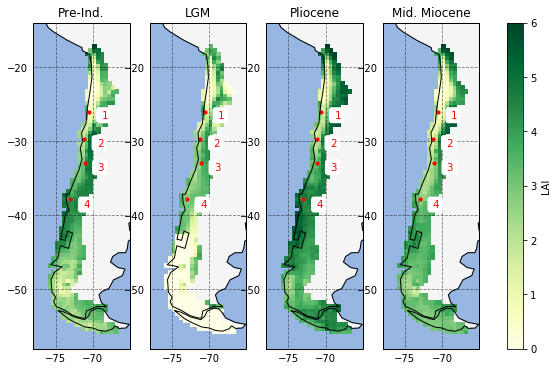

In [8]:
# plot average LAI
fig, axes = plt.subplots(1, len(ts), subplot_kw={'projection': ccrs.PlateCarree()})

for t, ax in zip(ts, axes.flatten()):
    p = ds[t].tot_sp_lai.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='YlGn', vmin=0, vmax=6, add_colorbar=False)
    beautify_map(ax, label=tsl[t], add_marker=True)
fig.colorbar(p, ax=axes.ravel().tolist()).set_label('LAI');

plt.gcf().set_size_inches(10, 6) # bigger plot

### Vegetation cover

In [9]:
# convert LAI to FPC
import numpy as np
for t in ts:
    ds[t]['vegcover'] = (1.0 - np.exp(-0.5 * ds[t]['tot_sp_lai'])) * 100

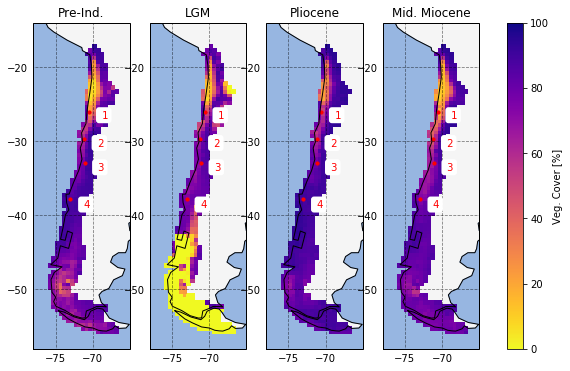

In [10]:
# plot average veg cover
fig, axes = plt.subplots(1, len(ts), subplot_kw={'projection': ccrs.PlateCarree()})

for t, ax in zip(ts, axes.flatten()):
    p = ds[t].vegcover.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='plasma_r', vmin=0, vmax=100, add_colorbar=False)
    beautify_map(ax, label=tsl[t], add_marker=True)
fig.colorbar(p, ax=axes.ravel().tolist()).set_label('Veg. Cover [%]');

plt.gcf().set_size_inches(10, 6) # bigger plot